In [1]:
from datetime import datetime, timedelta, timezone

#from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend

from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig


The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
# Render plots inline
%matplotlib inline

In [3]:
SIMULATOR_BACKEND = SimulatorBackend.OSKAR

In [4]:
sky_model = SkyModel.get_MIGHTEE_Sky()

In [5]:
# Phase center: should be mean of coverage
# Means of values from sky model description
phase_center_ra = 150.12
phase_center_dec = 2.21
phase_center = [phase_center_ra, phase_center_dec]

In [6]:
# From sky model description
start_frequency_hz = 1.304e9
end_frequency_hz = 1.375e9
# ~ center frequency
observation_start_frequency_hz = 1.34e9

# From survey metadata
frequency_increment_hz = 26123

# Size of generated visibilities scales linearly with this
number_of_channels = 8

# Original survey: 3593 dumps => Size: 6668.534 GB
# Size of generated visibilities scales linearly with this
number_of_time_steps = 8

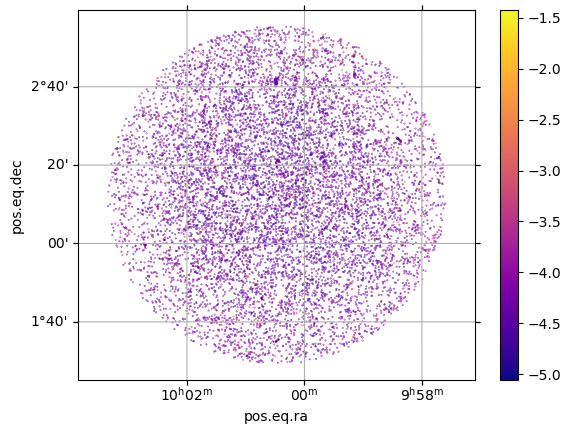

In [7]:
sky_model.setup_default_wcs(phase_center=phase_center)
sky_model.explore_sky(phase_center, s=0.1)

In [8]:
# Phase center: should be mean of coverage
# Means of values from sky model description
phase_center_ra = 150.12
phase_center_dec = 2.21
phase_center = [phase_center_ra, phase_center_dec]

In [9]:
simulation = InterferometerSimulation(
    channel_bandwidth_hz=frequency_increment_hz,
    station_type="Gaussian beam",
    gauss_beam_fwhm_deg=1.1832497493784,
    gauss_ref_freq_hz=1.34e9,
)

Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.


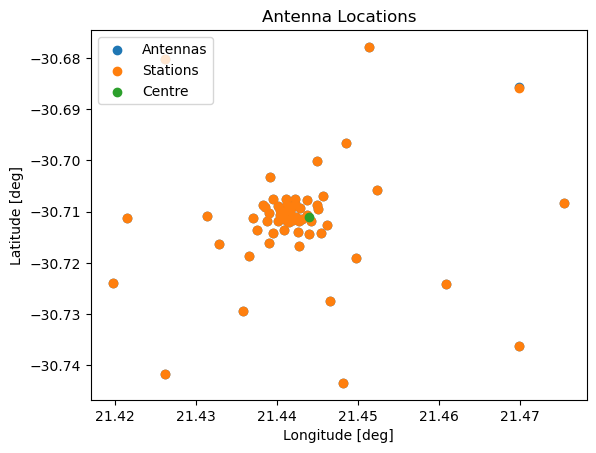

In [10]:
# Size of generated visibilities scales quadratically with the number of baselines
telescope = Telescope.constructor(
    name="MeerKAT",
    backend=SIMULATOR_BACKEND,
)

telescope.plot_telescope()

In [11]:
observation = Observation(
    phase_centre_ra_deg=phase_center_ra,
    phase_centre_dec_deg=phase_center_dec,
    # During the chosen time range [start, start + length]
    # sources shouldn't be behind horizon, otherwise we won't see much.
    # Original survey: 2020-04-26 14:36:50.820 UTC to 2020-04-26 22:35:42.665 UTC
    start_date_and_time=datetime(2020, 4, 26, 18, 36, 0, 0, timezone.utc),
    # Dump rate from survey metadata
    length=timedelta(seconds=number_of_time_steps * 7.997),
    number_of_time_steps=number_of_time_steps,
    number_of_channels=number_of_channels,
    start_frequency_hz=observation_start_frequency_hz,
    frequency_increment_hz=frequency_increment_hz,
)

In [12]:

visibility = simulation.run_simulation(
    telescope,
    sky_model,
    observation,
    backend=SIMULATOR_BACKEND,
)

path = visibility.ms_file_path
print(path)

Creating /tmp/karabo-STM-delberin-sg0RfTcMrA/interferometer-9bciumASMH for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-delberin-sg0RfTcMrA/interferometer-9bciumASMH/visibility.vis
/tmp/karabo-STM-delberin-sg0RfTcMrA/interferometer-9bciumASMH/measurements.MS


Creating /tmp/karabo-STM-delberin-sg0RfTcMrA/Imager-Dirty-PC3aHUWxOS for disk-cache for dirty.fits


/home/delberin/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/imaging/image.py:118: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


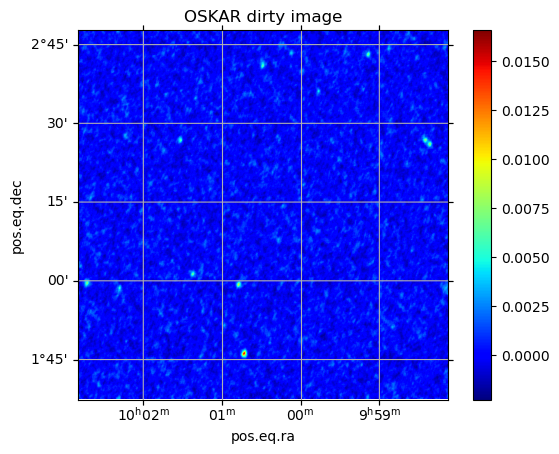

Creating /tmp/karabo-STM-delberin-sg0RfTcMrA/Imager-Dirty-YCa2n6Z6cv for disk-cache for dirty.fits


In [15]:
image_npixel = 4096
cellsize = 5e-6  # FOV / image_npixel

oskar_imager = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=image_npixel,
        imaging_cellsize=cellsize,
        combine_across_frequencies=True
    )
)

rascil_imager = RascilDirtyImager(
    RascilDirtyImagerConfig(
        imaging_npixel=image_npixel,
        imaging_cellsize=cellsize,
        combine_across_frequencies=True,
    )
)

# Calculate dirty images with the imagers
oskar_dirty_image = oskar_imager.create_dirty_image(visibility)
oskar_dirty_image.plot(
    title="OSKAR dirty image",
    filename="oskar_dirty_image.png"
)

rascil_dirty_image = rascil_imager.create_dirty_image(visibility)
